# PROGRAMA DE FORMAÇÃO LIGHTHOUSE - INDICIUM 
## MODELO PREDITIVO DE PRECIFICAÇÃO DE DIÁRIAS DE IMÓVEIS

# Objeto do estudo

A motivação desse projeto é auxiliar no processo de criação de uma plataforma de aluguéis temporários na cidade de Nova York, mais especificamente colaborando no desenvolvimento de uma estratégia de precificação das diárias. A seguir temos uma análise exploratória dos dados já existentes de uma plataforma concorrente, assim como testes de validação de modelos preditivos de precificação com base nesses dados. Como estamos buscando prever uma variável target contínua, trata-se de um problema de regressão.


In [388]:
#Importando as bibliotecas de manipulação/visualização de dados e de modelos de machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score


#Configurando pandas para mostrar todas linhas e colunas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Configurando pandas para não mostrar notação científica para números
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [389]:
#Carregando os dados existentes em um DataFrame pandas
df = pd.read_csv('teste_indicium_precificacao.csv', index_col=0)

In [390]:
#Primeiras impressões do dataset
df.head()

,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
id,,,,,,,,,,,,,,,
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.75,-73.97,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [391]:
#Total de linhas e colunas do DataFrame
df.shape

(48894, 15)

# Tratamento dos dados

Remoção de colunas que não serão utilizadas, remoção de outliers, ajuste da coluna de datas

In [392]:
#Analisando os tipos dos dados e valores nulos para tratamento
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48894 entries, 2595 to 36487245
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   nome                           48878 non-null  object 
 1   host_id                        48894 non-null  int64  
 2   host_name                      48873 non-null  object 
 3   bairro_group                   48894 non-null  object 
 4   bairro                         48894 non-null  object 
 5   latitude                       48894 non-null  float64
 6   longitude                      48894 non-null  float64
 7   room_type                      48894 non-null  object 
 8   price                          48894 non-null  int64  
 9   minimo_noites                  48894 non-null  int64  
 10  numero_de_reviews              48894 non-null  int64  
 11  ultima_review                  38842 non-null  object 
 12  reviews_por_mes                38842 non-null

In [393]:
#Removendo colunas que não fazem sentido para o objeto do estudo
colunas_remover = ['host_id', 'host_name', 'calculado_host_listings_count', 'latitude', 'longitude']
df = df.drop(columns = colunas_remover)
df.shape

(48894, 10)

In [394]:
#Primeiros insights sobre os percentis
df.describe()

,price,minimo_noites,numero_de_reviews,reviews_por_mes,disponibilidade_365
count,48894.00,48894.00,48894.00,38842.00,48894.00
mean,152.72,7.03,23.27,1.37,112.78
std,240.16,20.51,44.55,1.68,131.62
min,0.00,1.00,0.00,0.01,0.00
25%,69.00,1.00,1.00,0.19,0.00
50%,106.00,3.00,5.00,0.72,45.00
75%,175.00,5.00,24.00,2.02,227.00
max,10000.00,1250.00,629.00,58.50,365.00


In [395]:
#Analisando os percentis da coluna 'price' sem os outliers (Até o percentil 90%)
df['price'].describe(percentiles=[.90])

count   48894.00
mean      152.72
std       240.16
min         0.00
50%       106.00
90%       269.00
max     10000.00
Name: price, dtype: float64

In [396]:
#Tratando os outliers da coluna 'price'  
limite1 = df['price'].quantile(0.90)
df = df[df['price'] <= limite1]
df.describe()

,price,minimo_noites,numero_de_reviews,reviews_por_mes,disponibilidade_365
count,44016.00,44016.00,44016.00,35572.00,44016.00
mean,112.33,6.89,24.18,1.38,107.84
std,58.56,19.95,45.62,1.69,129.78
min,0.00,1.00,0.00,0.01,0.00
25%,65.00,1.00,1.00,0.19,0.00
50%,100.00,2.00,6.00,0.71,37.00
75%,150.00,5.00,25.00,2.02,211.00
max,269.00,1250.00,629.00,58.50,365.00


In [397]:
#Convertendo a coluna de datas para o tipo datetime e transformando os valores em total de dias desde a última review até o dia atual
df['ultima_review'] = pd.to_datetime(df['ultima_review'])
df['dias_da_ultima_review'] = (pd.to_datetime('today') - df['ultima_review']).dt.days
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44016 entries, 2595 to 36487245
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   nome                   44002 non-null  object        
 1   bairro_group           44016 non-null  object        
 2   bairro                 44016 non-null  object        
 3   room_type              44016 non-null  object        
 4   price                  44016 non-null  int64         
 5   minimo_noites          44016 non-null  int64         
 6   numero_de_reviews      44016 non-null  int64         
 7   ultima_review          35572 non-null  datetime64[ns]
 8   reviews_por_mes        35572 non-null  float64       
 9   disponibilidade_365    44016 non-null  int64         
 10  dias_da_ultima_review  35572 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 4.0+ MB


In [398]:
#Remoção da coluna 'ultima_review'
df = df.drop(columns = 'ultima_review')
df.head()

,nome,bairro_group,bairro,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,disponibilidade_365,dias_da_ultima_review
id,,,,,,,,,,
2595,Skylit Midtown Castle,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,355,1724.00
3647,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,Private room,150,3,0,NaN,365,NaN
3831,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,194,1679.00
5022,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,0,1907.00
5099,Large Cozy 1 BR Apartment In Midtown East,Manhattan,Murray Hill,Entire home/apt,200,3,74,0.59,129,1692.00


# Análise exploratória dos dados
Conhecer as medidas estatísticas, de tendência central, dispersão, separatrizes, distribuições e correlações.

In [399]:
#Medidas das colunas que já são numéricas. O tratamento de valores nulos será feito após o split das bases para evitar data leakeage
df.describe()

,price,minimo_noites,numero_de_reviews,reviews_por_mes,disponibilidade_365,dias_da_ultima_review
count,44016.00,44016.00,44016.00,35572.00,44016.00,35572.00
mean,112.33,6.89,24.18,1.38,107.84,1956.08
std,58.56,19.95,45.62,1.69,129.78,414.99
min,0.00,1.00,0.00,0.01,0.00,1676.00
25%,65.00,1.00,1.00,0.19,0.00,1691.00
50%,100.00,2.00,6.00,0.71,37.00,1726.00
75%,150.00,5.00,25.00,2.02,211.00,2050.00
max,269.00,1250.00,629.00,58.50,365.00,4700.00


<Axes: xlabel='price', ylabel='Count'>

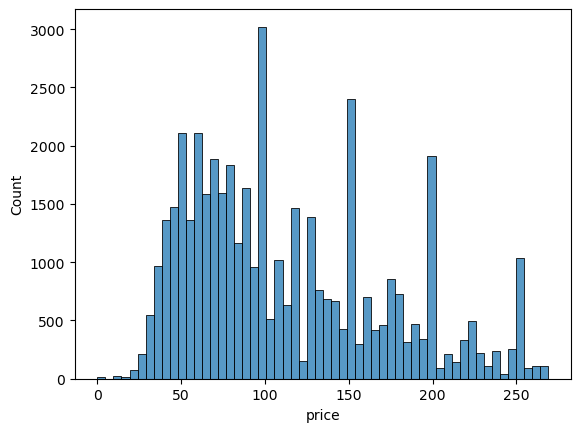

In [400]:
#Analisando a distribuição de preços
sns.histplot(df, x='price')

<Axes: xlabel='bairro_group', ylabel='count'>

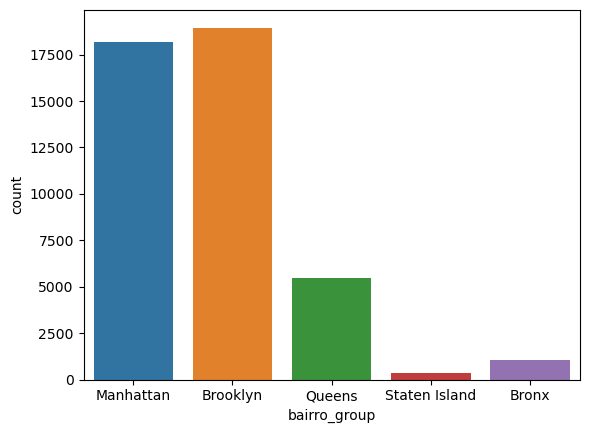

In [401]:
#Comparação da quantidade de anúncios em cada 'bairro_group'
sns.countplot(df, x='bairro_group')

In [402]:
#Analisando a quantidade de anúncios por 'bairro'
df['bairro'].value_counts().sort_values(ascending=False)

bairro
Bedford-Stuyvesant            3597
Williamsburg                  3571
Harlem                        2523
Bushwick                      2422
Upper West Side               1661
East Village                  1599
Hell's Kitchen                1586
Upper East Side               1582
Crown Heights                 1482
East Harlem                   1055
Greenpoint                    1043
Midtown                       1004
Washington Heights             877
Astoria                        872
Chelsea                        832
Lower East Side                810
Flatbush                       603
Financial District             596
West Village                   568
Clinton Hill                   521
Prospect-Lefferts Gardens      520
Long Island City               502
East Flatbush                  487
Fort Greene                    447
Park Slope                     445
Ridgewood                      417
Flushing                       411
Murray Hill                    386
Kips Bay     

In [403]:
#Substituindo os valores dos bairros com menos de 50 anúncios por NaN
contagem_valores = df['bairro'].value_counts()
valores_menor_50 = contagem_valores[contagem_valores < 50].index
df.loc[df['bairro'].isin(valores_menor_50), 'bairro'] = pd.NA
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44016 entries, 2595 to 36487245
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   nome                   44002 non-null  object 
 1   bairro_group           44016 non-null  object 
 2   bairro                 42122 non-null  object 
 3   room_type              44016 non-null  object 
 4   price                  44016 non-null  int64  
 5   minimo_noites          44016 non-null  int64  
 6   numero_de_reviews      44016 non-null  int64  
 7   reviews_por_mes        35572 non-null  float64
 8   disponibilidade_365    44016 non-null  int64  
 9   dias_da_ultima_review  35572 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 3.7+ MB


<Axes: xlabel='room_type', ylabel='count'>

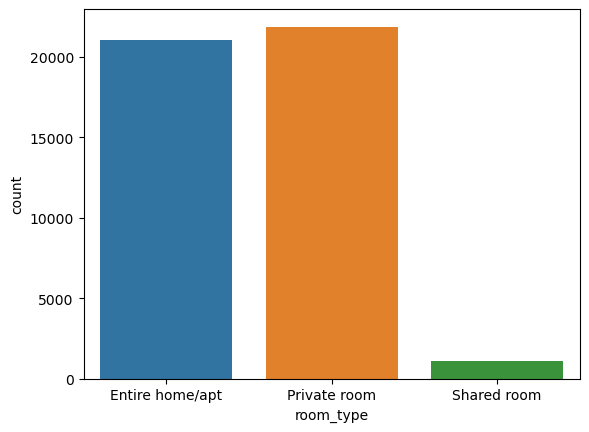

In [404]:
#Comparação da quantidade de anúncios em cada valor de 'room_type'
sns.countplot(df, x='room_type')

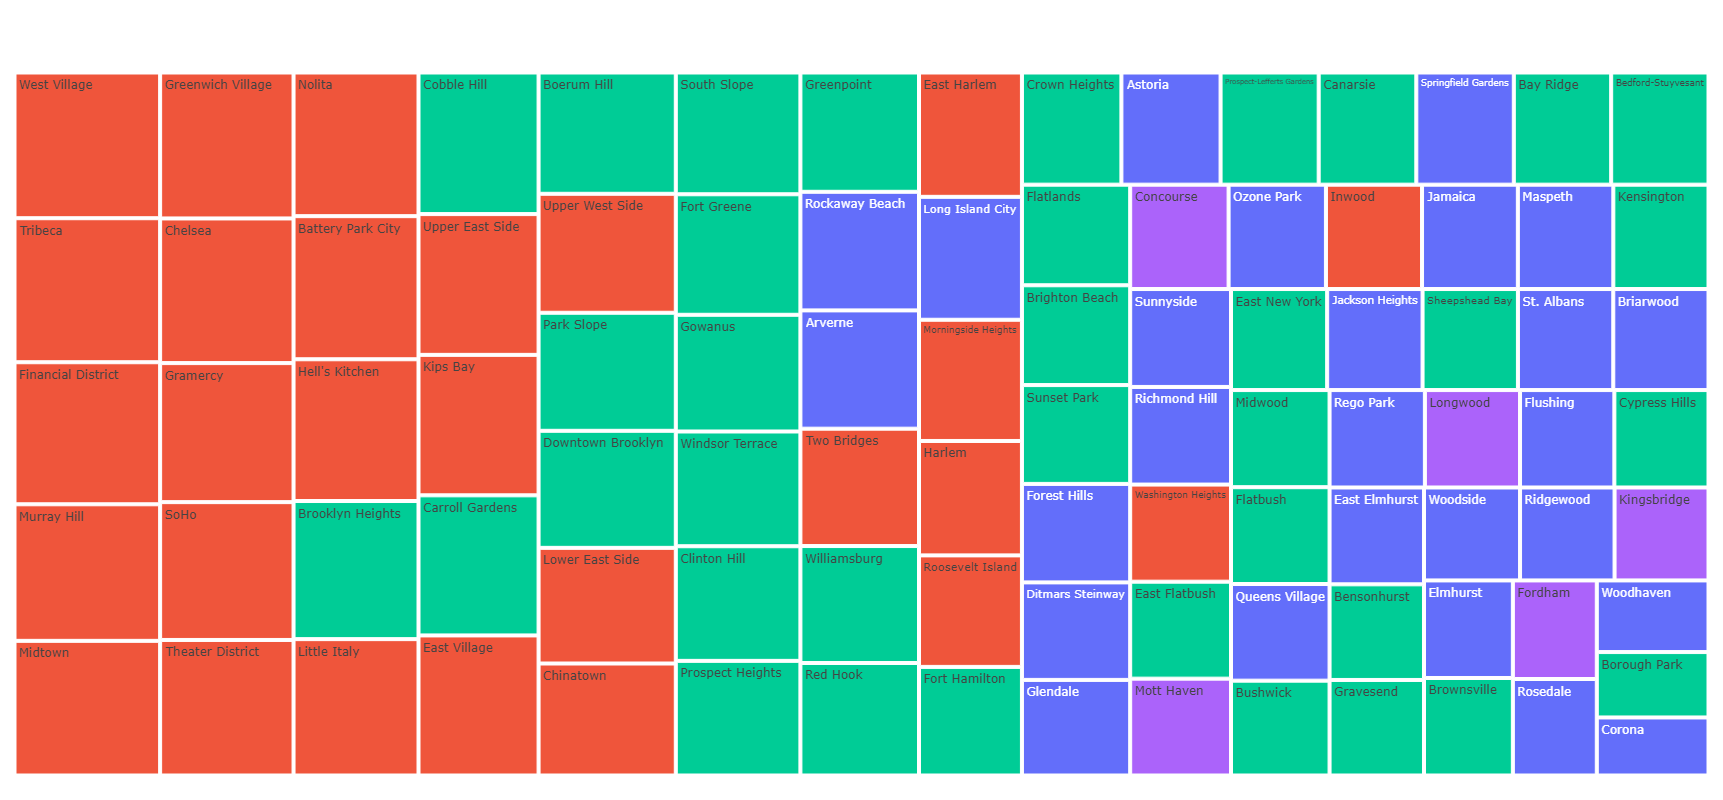

In [405]:
#Calculando a média de preço por bairro e atribuindo em um DataFrame
media_preco_por_bairro = df.groupby(['bairro_group','bairro'])['price'].mean().reset_index()

#Plotando o gráfico treemap onde cada caixa é um 'bairro', classificados por cores iguais conforme o seu 'bairro_group', e quanto maior a caixa, maior a média de preço do 'bairro'
fig = px.treemap(media_preco_por_bairro, 
                 path=['bairro'], 
                 values='price',
                 color='bairro_group',
                 color_continuous_scale='viridis',
                 width=1600, height=800)

fig.update_layout(margin = dict(t=50, l=10, r=10, b=20))
fig.show()

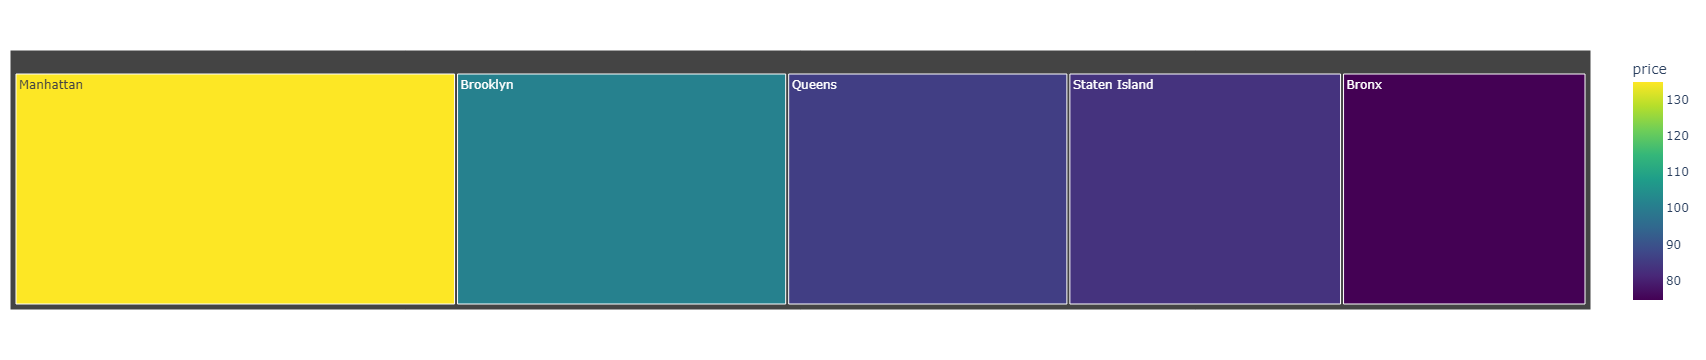

In [406]:
#Calculando a média de preço por bairro_group e atribuindo em um DataFrame
media_preco_por_grupo = df.groupby(['bairro_group'])['price'].mean().reset_index()

#Plotando o gráfico treemap onde cada caixa é um 'bairro_group', e quanto maior a caixa, maior a média de preços desse 'bairro_group'
fig = px.treemap(media_preco_por_grupo, 
                 path=['bairro_group'], 
                 values='price',
                 color='price',
                 color_continuous_scale='viridis',
                 width=1000, height=350)

fig.update_layout(margin = dict(t=50, l=10, r=10, b=50))
fig.show()

C:\Users\lucas.stein\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



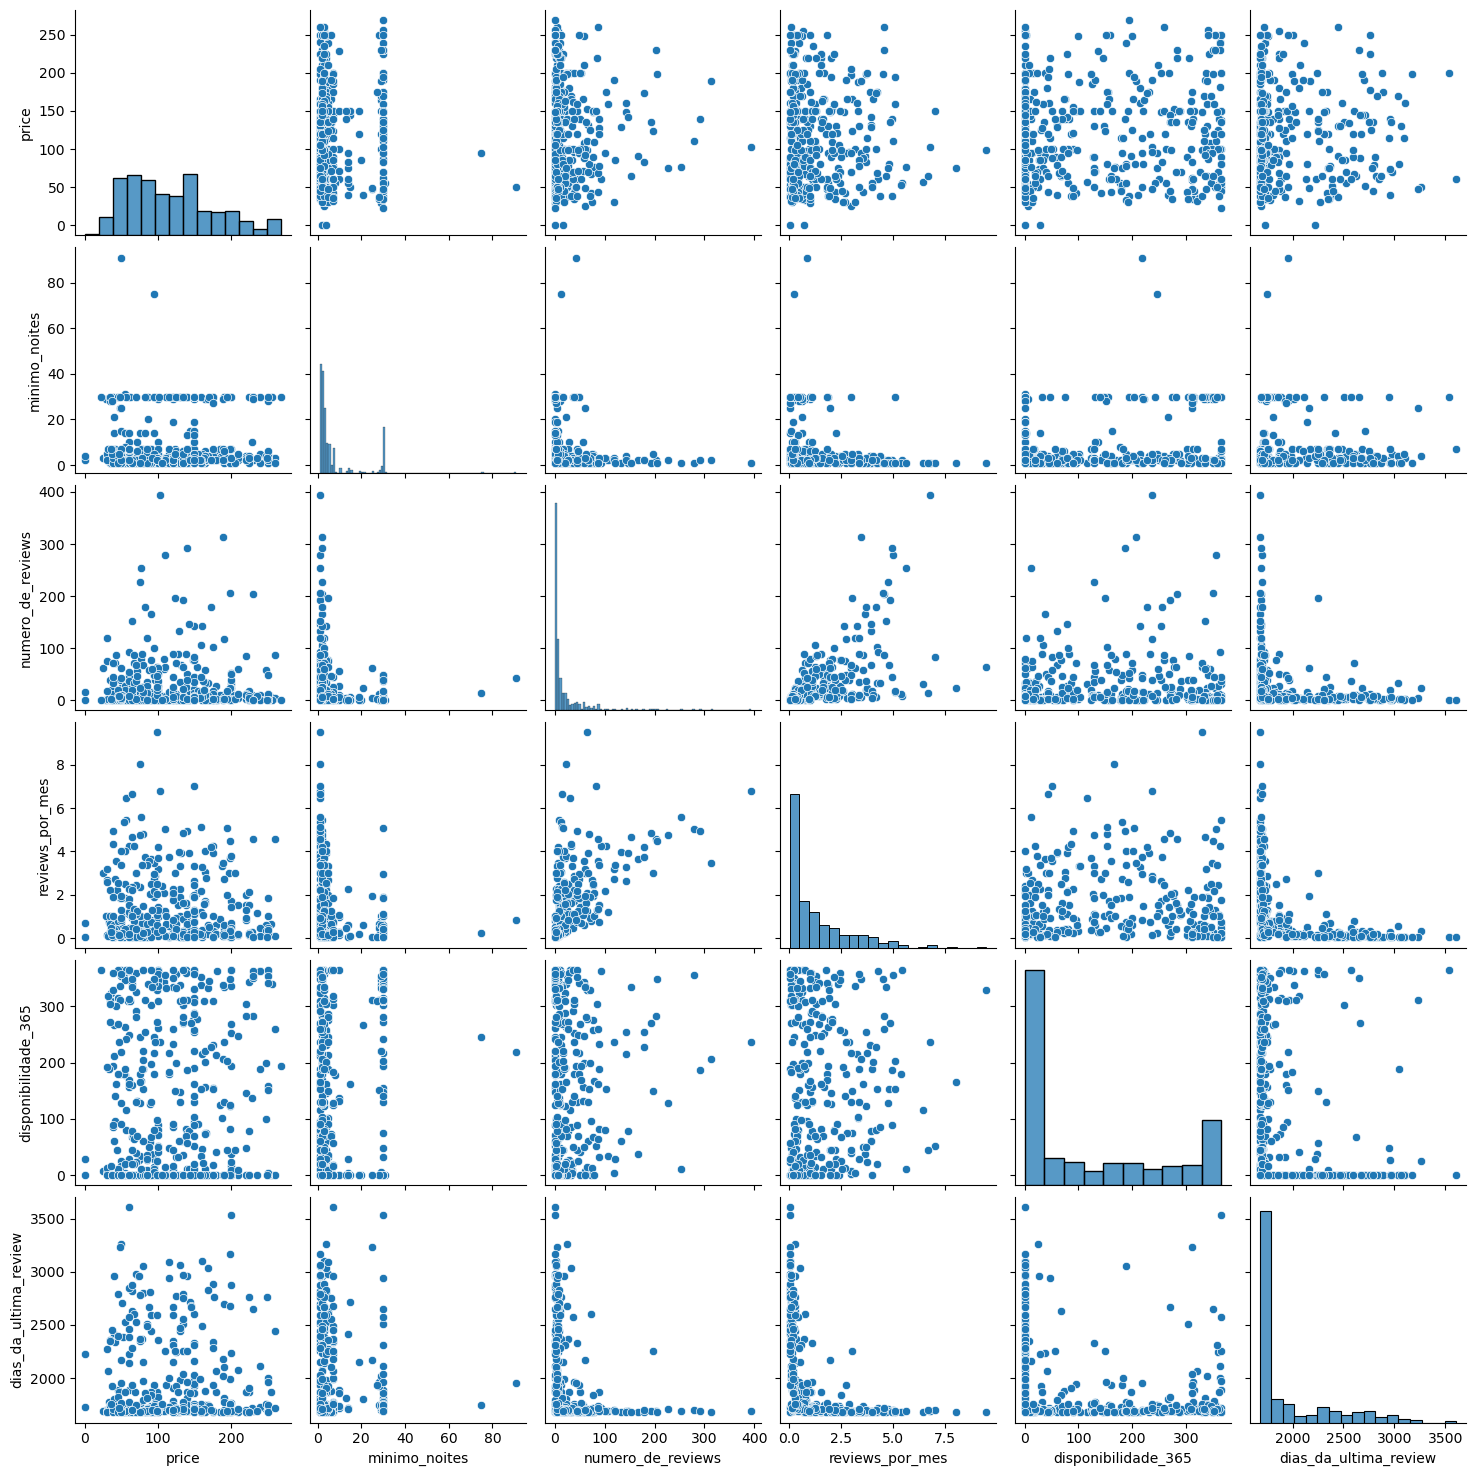

In [407]:
#Correlação entre os pares das variáveis
sns.pairplot(df.sample(500))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucas.stein\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucas.stein\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


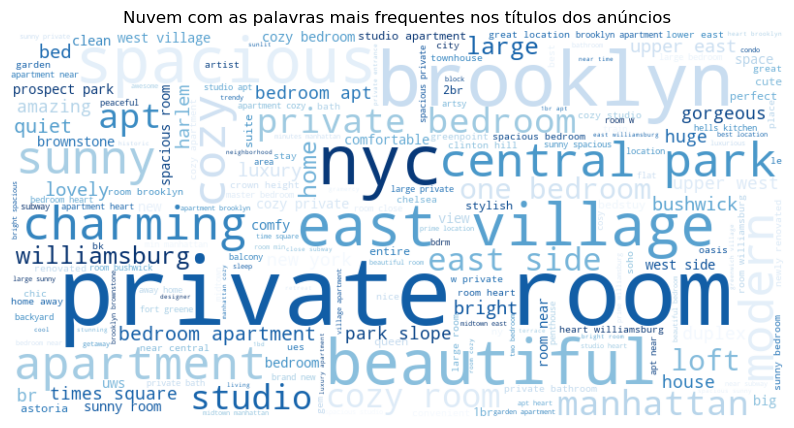

In [408]:
#Importando as bibliotecas necessárias para plotar gráfico de nuvens com as palavras mais frequentes na coluna 'nome'
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#Baixando as stopwords do NLTK
nltk.download('stopwords')
nltk.download('punkt')

#Tratamento de valores nulos
df['nome'].fillna('', inplace=True)

#Removendo pontuações e convertendo para letras minúsculas
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    return text

#Aplicando o pré-processamento dos textos na coluna 'nome' 
df['nome'] = df['nome'].apply(preprocess_text)

#Realizando a tokenização e remoção das stopwords
stop_words = set(stopwords.words('english'))
df['nome'] = df['nome'].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])

#Criando uma lista de palavras mais frequentes
palavras = [palavra for lista in df['nome'].tolist() for palavra in lista]

#Criando uma string única com todas as palavras
text = ' '.join(palavras)

#Criando a nuvem de palavras
nuvem = WordCloud(width=800, height=400, background_color ='white', stopwords = stop_words, colormap='Blues').generate(text)

#Plotando a nuvem de palavras mais frequentes
plt.figure(figsize=(10, 6))
plt.imshow(nuvem, interpolation='bilinear')
plt.title('Nuvem com as palavras mais frequentes nos títulos dos anúncios')
plt.axis('off')
plt.show()

In [409]:
#Como a coluna 'nome' é infinitamente editável, não faz sentido mantermos para utilização no modelo, por isso será removida
df = df.drop(columns = 'nome')

#Como a variável 'dias_da_ultima_review' está com valores claramente distantes da data atual, provavelmente por ser um dataset antigo, vamos remover essa coluna
df = df.drop(columns = 'dias_da_ultima_review')

df.shape

(44016, 8)

## Conclusão da etapa de exploração dos dados

Podemos ver que os anúncios são predominantemente concentrados em dois principais grupos de bairros de NY, são eles: Manhattan e Brooklyn.

Além disso, esses dois grupos também são os que tem a duas maiores médias de preços entre todas as localizações.

Levando em consideração os bairros em uma granularidade mais baixa, temos que os 5 bairros com maior média de preços são: West Village, Tribeca, Financial District, Murray Hill e Midtown. Sendo assim, caso alguém tenha o interesse de comprar um imóvel em NY para alugar por diárias, os bairros em que o imóvel poderia ser alugado por valores maiores, seriam estes citados.

Já com relação ao título do anúncio, as palavras que são mais frequentemente utilizadas são: beautiful, east village, brooklyn, central park, apartment, private room e spacious.

Com essas informações, podemos entender que as localizações mais buscadas quando se trata de hospedagem em NY são Manhattan e Brooklyn, sendo assim, é válido sugerir como um insight valioso para a empresa que está criando uma plataforma de aluguéis temporários, que foquem seus esforços de captação em proprietários que alugam imóveis nessas regiões.


# Codificação das variáveis categóricas

1. Coluna 'bairro' - Ordinal Encoding utilizando como base a ordem de média de preços do menor pro maior

In [410]:
#Calculando a média dos preços por bairro
media_precos_por_bairro = df.groupby('bairro')['price'].mean()

#Ordenando os bairros com base na média de preço
bairros_ordenados_por_preco = media_precos_por_bairro.sort_values().index

#Criando um dicionário para mapear os bairros para seus rótulos ordinais
mapeamento_ordem = {bairro: indice for indice, bairro in enumerate(bairros_ordenados_por_preco)}

#Aplicando o Ordinal Encoding ao DataFrame 
df['bairro_codificado'] = df['bairro'].map(mapeamento_ordem)

2. Coluna 'bairro_group' - Ordinal Encoding utilizando como base a ordem de média de preços do menor pro maior

In [411]:
#Calculando a média dos preços por grupo
media_precos_por_bairro_group = df.groupby('bairro_group')['price'].mean()

#Ordenando os grupos com base na média de preço
grupos_ordenados_por_preco = media_precos_por_bairro_group.sort_values().index

#Criando um dicionário para mapear os grupos para seus rótulos ordinais
mapeamento_ordem = {grupo: indice for indice, grupo in enumerate(grupos_ordenados_por_preco)}

#Aplicando o Ordinal Encoding ao DataFrame
df['grupo_codificado'] = df['bairro_group'].map(mapeamento_ordem)

3. Coluna 'room_type' - OneHotEncoder

In [412]:
#Criando uma coluna para cada valor presente em 'room_type'
ohe = pd.get_dummies(df['room_type'])
df = df.join(ohe)

In [413]:
#Removendo as colunas categóricas originais
remover = ['bairro_group', 'bairro', 'room_type']
df = df.drop(columns = remover)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44016 entries, 2595 to 36487245
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                44016 non-null  int64  
 1   minimo_noites        44016 non-null  int64  
 2   numero_de_reviews    44016 non-null  int64  
 3   reviews_por_mes      35572 non-null  float64
 4   disponibilidade_365  44016 non-null  int64  
 5   bairro_codificado    42122 non-null  float64
 6   grupo_codificado     44016 non-null  int64  
 7   Entire home/apt      44016 non-null  bool   
 8   Private room         44016 non-null  bool   
 9   Shared room          44016 non-null  bool   
dtypes: bool(3), float64(2), int64(5)
memory usage: 3.8 MB


# Matriz de correlação

Agora que temos todas as variáveis com os tipos numéricos, vamos analisar a correlação entre todas as variáveis

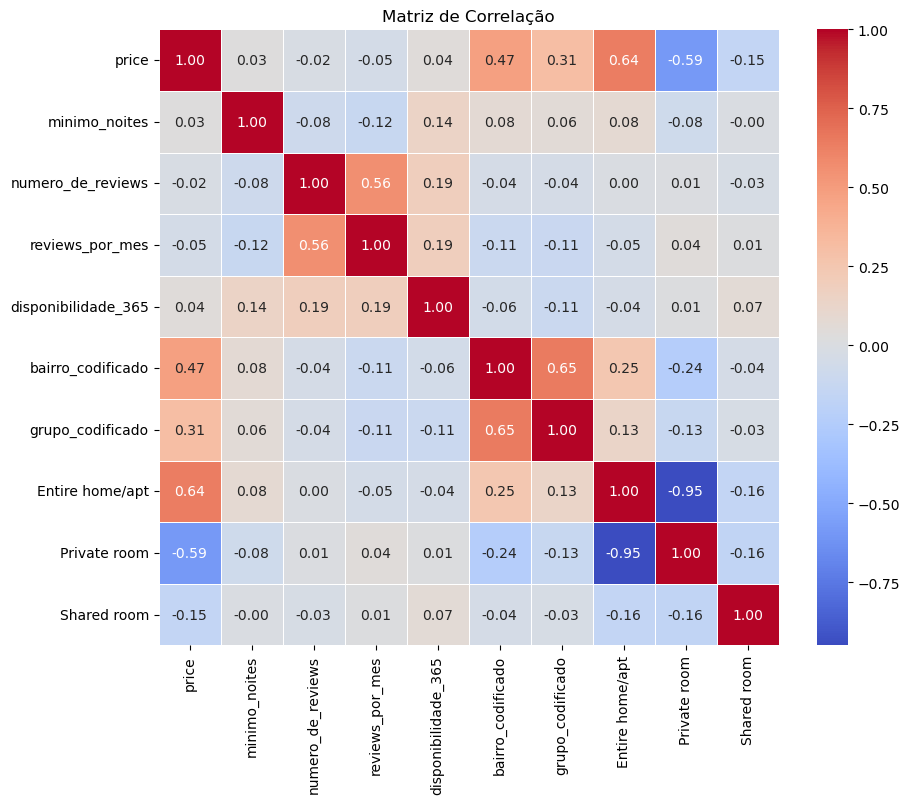

In [414]:
#Atribuindo a matriz de correlação
matriz_correlacao = df.corr()

#Plotando a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

# Fazendo o split de bases e preparando os dados para o modelo de machine learning

Separando em treino e teste e ajustando todos os dados para variáveis numéricas

In [415]:
#Separando variáveis preditoras e target
x = df.drop(['price'], axis=1)
y = df[['price']]

In [416]:
#Split de bases de treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

## Tratamento de valores nulos

In [417]:
#Nulos na base de treino

moda_bairro = x_train['bairro_codificado'].mode()[0]
x_train['bairro_codificado'] = x_train['bairro_codificado'].fillna(moda_bairro)

moda_reviews_mes = x_train['reviews_por_mes'].mode()[0]
x_train['reviews_por_mes'] = x_train['reviews_por_mes'].fillna(moda_reviews_mes)

In [418]:
#Nulos na base de teste

moda_bairro2 = x_test['bairro_codificado'].mode()[0]
x_test['bairro_codificado'] = x_test['bairro_codificado'].fillna(moda_bairro2)

moda_reviews_mes2 = x_test['reviews_por_mes'].mode()[0]
x_test['reviews_por_mes'] = x_test['reviews_por_mes'].fillna(moda_reviews_mes2)

In [419]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39614 entries, 15854548 to 13688316
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   minimo_noites        39614 non-null  int64  
 1   numero_de_reviews    39614 non-null  int64  
 2   reviews_por_mes      39614 non-null  float64
 3   disponibilidade_365  39614 non-null  int64  
 4   bairro_codificado    39614 non-null  float64
 5   grupo_codificado     39614 non-null  int64  
 6   Entire home/apt      39614 non-null  bool   
 7   Private room         39614 non-null  bool   
 8   Shared room          39614 non-null  bool   
dtypes: bool(3), float64(2), int64(4)
memory usage: 2.2 MB


## Scaling - Log Transformation

In [420]:
#Tranformando os dados em logarítmicos e normalizando

x_train_log = x_train.apply(np.log1p)
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_log)
x_train = pd.DataFrame(x_train_scaled, columns=x_train.columns, index=x_train.index)

x_test_log = x_test.apply(np.log1p)
scaler = MinMaxScaler()
x_test_scaled = scaler.fit_transform(x_test_log)
x_test = pd.DataFrame(x_test_scaled, columns=x_test.columns, index=x_test.index)

In [421]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39614 entries, 15854548 to 13688316
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   minimo_noites        39614 non-null  float64
 1   numero_de_reviews    39614 non-null  float64
 2   reviews_por_mes      39614 non-null  float64
 3   disponibilidade_365  39614 non-null  float64
 4   bairro_codificado    39614 non-null  float64
 5   grupo_codificado     39614 non-null  float64
 6   Entire home/apt      39614 non-null  float64
 7   Private room         39614 non-null  float64
 8   Shared room          39614 non-null  float64
dtypes: float64(9)
memory usage: 3.0 MB


# Treinamento dos modelos na base treino

1. Regressão Linear

In [422]:
#Criando objeto de regressão linear
mdl_regressao_linear = LinearRegression()
mdl_regressao_linear.fit(x_train, y_train)

LinearRegression()

In [423]:
#Cross validation com r2_score
scores_regressao_linear = cross_val_score(mdl_regressao_linear, x_train, y_train, scoring='r2', cv=5)
scores_regressao_linear

array([0.50037969, 0.51440208, 0.50940957, 0.51856051, 0.50625616])

In [424]:
#Média do cross validation
scores_regressao_linear.mean()

0.5098016026716327

2. Árvore de decisão

In [425]:
#Criando objeto de Árvore de decisão
mdl_arvore = DecisionTreeRegressor(max_depth=5)
mdl_arvore.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [426]:
#Cross validation com r2_score
scores_arvore = cross_val_score(mdl_arvore, x_train, y_train, scoring='r2', cv=5)
scores_arvore

array([0.53000165, 0.54425796, 0.5479483 , 0.55386561, 0.53438625])

In [427]:
#Média do cross validation
scores_arvore.mean()

0.5420919543196537

3. KNN

In [428]:
#Criando objeto de KNN
mdl_knn = KNeighborsRegressor(n_neighbors=20)
mdl_knn.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=20)

In [429]:
#Cross validation com r2_score
scores_knn = cross_val_score(mdl_knn, x_train, y_train, scoring='r2', cv=5)
scores_knn

array([0.53852471, 0.54335151, 0.54742386, 0.55498644, 0.54399905])

In [430]:
#Média do cross validation
scores_knn.mean()

0.545657115279493

4. Regressão Lasso

In [431]:
#Criando objeto de Regressão Lasso
mdl_lasso = Lasso(alpha=0.1)
mdl_lasso.fit(x_train, y_train)

Lasso(alpha=0.1)

In [432]:
#Cross validation com r2_score
scores_lasso = cross_val_score(mdl_lasso, x_train, y_train, scoring='r2', cv=5)
scores_lasso

array([0.49908649, 0.51370091, 0.50823115, 0.51705347, 0.50557804])

In [433]:
#Média do cross validation
scores_lasso.mean()

0.5087300130042929

# Predição do modelo campeão na base teste

In [434]:
#Predição do modelo KNN na base de teste
predicoes = mdl_knn.predict(x_test)

In [435]:
#R2 error score
error_score = r2_score(y_test, predicoes)
print("R squared Error : ", error_score)

R squared Error :  0.5464139346092791


## Predição do anúncio selecionado

Realizando a predição em um anúncio da base fornecida com o id 2595

In [436]:
#Colunas que foram utilizadas no modelo
x_test.columns

Index(['minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
       'disponibilidade_365', 'bairro_codificado', 'grupo_codificado',
       'Entire home/apt', 'Private room', 'Shared room'],
      dtype='object')

In [437]:
#Características do anúncio
df.loc[2595]

price                    225
minimo_noites              1
numero_de_reviews         45
reviews_por_mes         0.38
disponibilidade_365      355
bairro_codificado      89.00
grupo_codificado           4
Entire home/apt         True
Private room           False
Shared room            False
Name: 2595, dtype: object

In [438]:
#Atribuindo as características em um DataFrame
anuncio = df.loc[[2595]]

#Retirando a coluna 'price'
anuncio = anuncio.drop(columns='price')

#Normalizando os valores conforme feito para a validação e teste
anuncio_log = anuncio.apply(np.log1p)
anuncio_scaled = scaler.transform(anuncio_log)
anuncio = pd.DataFrame(anuncio_scaled, columns=anuncio.columns, index=anuncio.index)
anuncio.head()

,minimo_noites,numero_de_reviews,reviews_por_mes,disponibilidade_365,bairro_codificado,grupo_codificado,Entire home/apt,Private room,Shared room
id,,,,,,,,,
2595,0.00,0.62,0.12,1.00,0.99,1.00,1.00,0.00,0.00


In [439]:
#Predição de valor do anúncio selecionado pelo modelo KNN
mdl_knn.predict(anuncio)

array([[200.15]])

In [448]:
#Analisando a média de preço na amostra da base de treino
y_test.mean()

price   113.14
dtype: float64

# Conclusão das predições
Portanto, com o modelo campeão validado e testado, temos um R2 score final de 0.54.

Com relação à predição do anúncio selecionado, o modelo previu um valor de 200.15, sendo o real valor de 225.

Se fizermos uma analogia entre inputar os preços com os novos dados que surgem pela média de preço da amostra da base de teste, teríamos que todos seriam inputados com o preço de 113.14. 

Já se utilizarmos o modelo KNN desenvolvido no presente estudo, e levando em consideração o que vimos na predição do anúncio selecionado acima, conforme o modelo, faríamos a inputação de 200.15, o que nos traz bem mais próximo do real valor anunciado de 225.

# Importação em arquivo pickle para deploy 

In [441]:
import joblib

with open('./Models/knn_model.pkl', 'wb') as arquivo_modelo:
   joblib.dump(mdl_knn, arquivo_modelo, compress=3)